## Building a simple statistical model to assess case study viability and assist callibration

### Questions:
* Do these commodity pathways explain the observed introductions?
* How prominent do we expect bridgehead introductions to be?
* How to expect to weight establishment vs. entry?


In [1]:
import pandas as pd
import numpy as np
import os
import glob
import geopandas as gpd
from functools import reduce

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from patsy import dmatrices
from sklearn.preprocessing import MinMaxScaler

In [2]:
google_root = 'Q:'
model_name = "ToBRFV_model" # Options: "slf_model", "mln_model", "ToBRFV_model"

data_path = f'{google_root}/Shared drives/Pandemic Data/{model_name}/'

# Path to formatted model inputs
if model_name == "slf_model":
    input_dir = data_path + "inputs/noTWN/"
else:
    input_dir = data_path + "inputs/"

# Path to save outputs
out_dir = data_path + "outputs/"

In [3]:
# Read in the data and create a simplest format - csv by country
countries_gdf = gpd.read_file(glob.glob(input_dir + "countries*.gpkg")[0])

# Validation data
validation = pd.read_csv(glob.glob(input_dir +'*first_records_validation.csv')[0])

# Origin data
origins = pd.read_csv(input_dir + 'origin_locations.csv')


In [4]:
# Binary of origins
countries_gdf.loc[countries_gdf['ISO3'].isin(origins.ISO3),'Origin'] = 1
countries_gdf.loc[~countries_gdf['ISO3'].isin(origins.ISO3),'Origin'] = 0

# Binary of destinations
countries_gdf.loc[countries_gdf['ISO3'].isin(validation.ISO3),'Destination'] = 1
countries_gdf.loc[~countries_gdf['ISO3'].isin(validation.ISO3),'Destination'] = 0


In [5]:
# Climate similarities matrix
climate_similarities = np.load(glob.glob(input_dir + "climate_similarities*.npy")[0])


In [6]:
# For each country, what is the max similarity to all pest origin locations?
countries_gdf['Climate_Max'] = np.max(climate_similarities[countries_gdf['Origin']==1], axis=0)

# countries_gdf['Climate_Mean'] = np.mean(climate_similarities[countries_gdf['Origin']==1], axis=0)

In [7]:
# Trade - two columns per commodity

# Total cumulative imports from (1) all source countries
# Total cumulative imports from (2) all validation countries

In [8]:
# Range of time for validation data
start_year = validation['ObsFirstIntro'].min() - 5
end_year = validation['ObsFirstIntro'].max() + 1

if model_name == "ToBRFV_model":
    start_year = 2010
    end_year = 2020

In [9]:
# Total trade data by commodity during the period of interest
# From source countries
# From validation countries (ie. potential bridgeheads)

year_range = list(range(start_year, end_year + 1, 1))
commodities = os.listdir(input_dir + 'comtrade/monthly_adjusted/')

for commodity in commodities: 
    
    try:
        del trade_sum
    except:
        print("Initializing...")
    for d in year_range:
        d_file_list = glob.glob(input_dir + f'/comtrade/monthly_adjusted/{commodity}/*_{d}*.csv')
        print(f'{commodity}, {d}: {len(d_file_list)}')
        dfs = [pd.read_csv(f, sep = ",", header= 0, index_col=0, encoding='latin1') for f in d_file_list]
        all_com = reduce(pd.DataFrame.add, dfs)
        try:
            trade_sum += all_com
            print('Added to trade_sum')
        except:
            trade_sum = all_com
            print('Created trade_sum')
    
    # Keep only origin exporters and other validation countries (bridgeheads)
    countries_gdf[f'Origin_{commodity}'] = trade_sum[origins.ISO3].sum(axis=1).reset_index(drop=True)
    countries_gdf[f'Origin_{commodity}'] = MinMaxScaler().fit_transform(np.array(countries_gdf[f'Origin_{commodity}']).reshape(-1,1))
    countries_gdf[f'Bridge_{commodity}'] = trade_sum[validation.ISO3].sum(axis=1).reset_index(drop=True)
    countries_gdf[f'Bridge_{commodity}'] = MinMaxScaler().fit_transform(np.array(countries_gdf[f'Bridge_{commodity}']).reshape(-1,1))
    print(f'{commodity} summed.\n')



Initializing...
0702, 2010: 12
Created trade_sum
0702, 2011: 12
Added to trade_sum
0702, 2012: 12
Added to trade_sum
0702, 2013: 12
Added to trade_sum
0702, 2014: 12
Added to trade_sum
0702, 2015: 12
Added to trade_sum
0702, 2016: 12
Added to trade_sum
0702, 2017: 12
Added to trade_sum
0702, 2018: 12
Added to trade_sum
0702, 2019: 12
Added to trade_sum
0702, 2020: 12
Added to trade_sum
0702 summed.

1209, 2010: 12
Created trade_sum
1209, 2011: 12
Added to trade_sum
1209, 2012: 12
Added to trade_sum
1209, 2013: 12
Added to trade_sum
1209, 2014: 12
Added to trade_sum
1209, 2015: 12
Added to trade_sum
1209, 2016: 12
Added to trade_sum
1209, 2017: 12
Added to trade_sum
1209, 2018: 12
Added to trade_sum
1209, 2019: 12
Added to trade_sum
1209, 2020: 12
Added to trade_sum
1209 summed.

0709, 2010: 12
Created trade_sum
0709, 2011: 12
Added to trade_sum
0709, 2012: 12
Added to trade_sum
0709, 2013: 12
Added to trade_sum
0709, 2014: 12
Added to trade_sum
0709, 2015: 12
Added to trade_sum
0709, 2

In [10]:
# Keep host area as is

countries_gdf['Host_Area'] = countries_gdf['Host Percent Area']

In [11]:
regression_df = countries_gdf.set_index('ISO3')
regression_df = regression_df.loc[:,'Origin':].reset_index()

In [12]:
regression_df.to_csv(data_path + "regression_data.csv", index=False)

## Analysis

In [13]:
# If you've already done the setup, read back in the regression data (or head over to R!)
regression_df = pd.read_csv(data_path + "regression_data.csv")
regression_data = regression_df.loc[regression_df['Origin']==0].reset_index(drop=True).drop(columns="Origin")


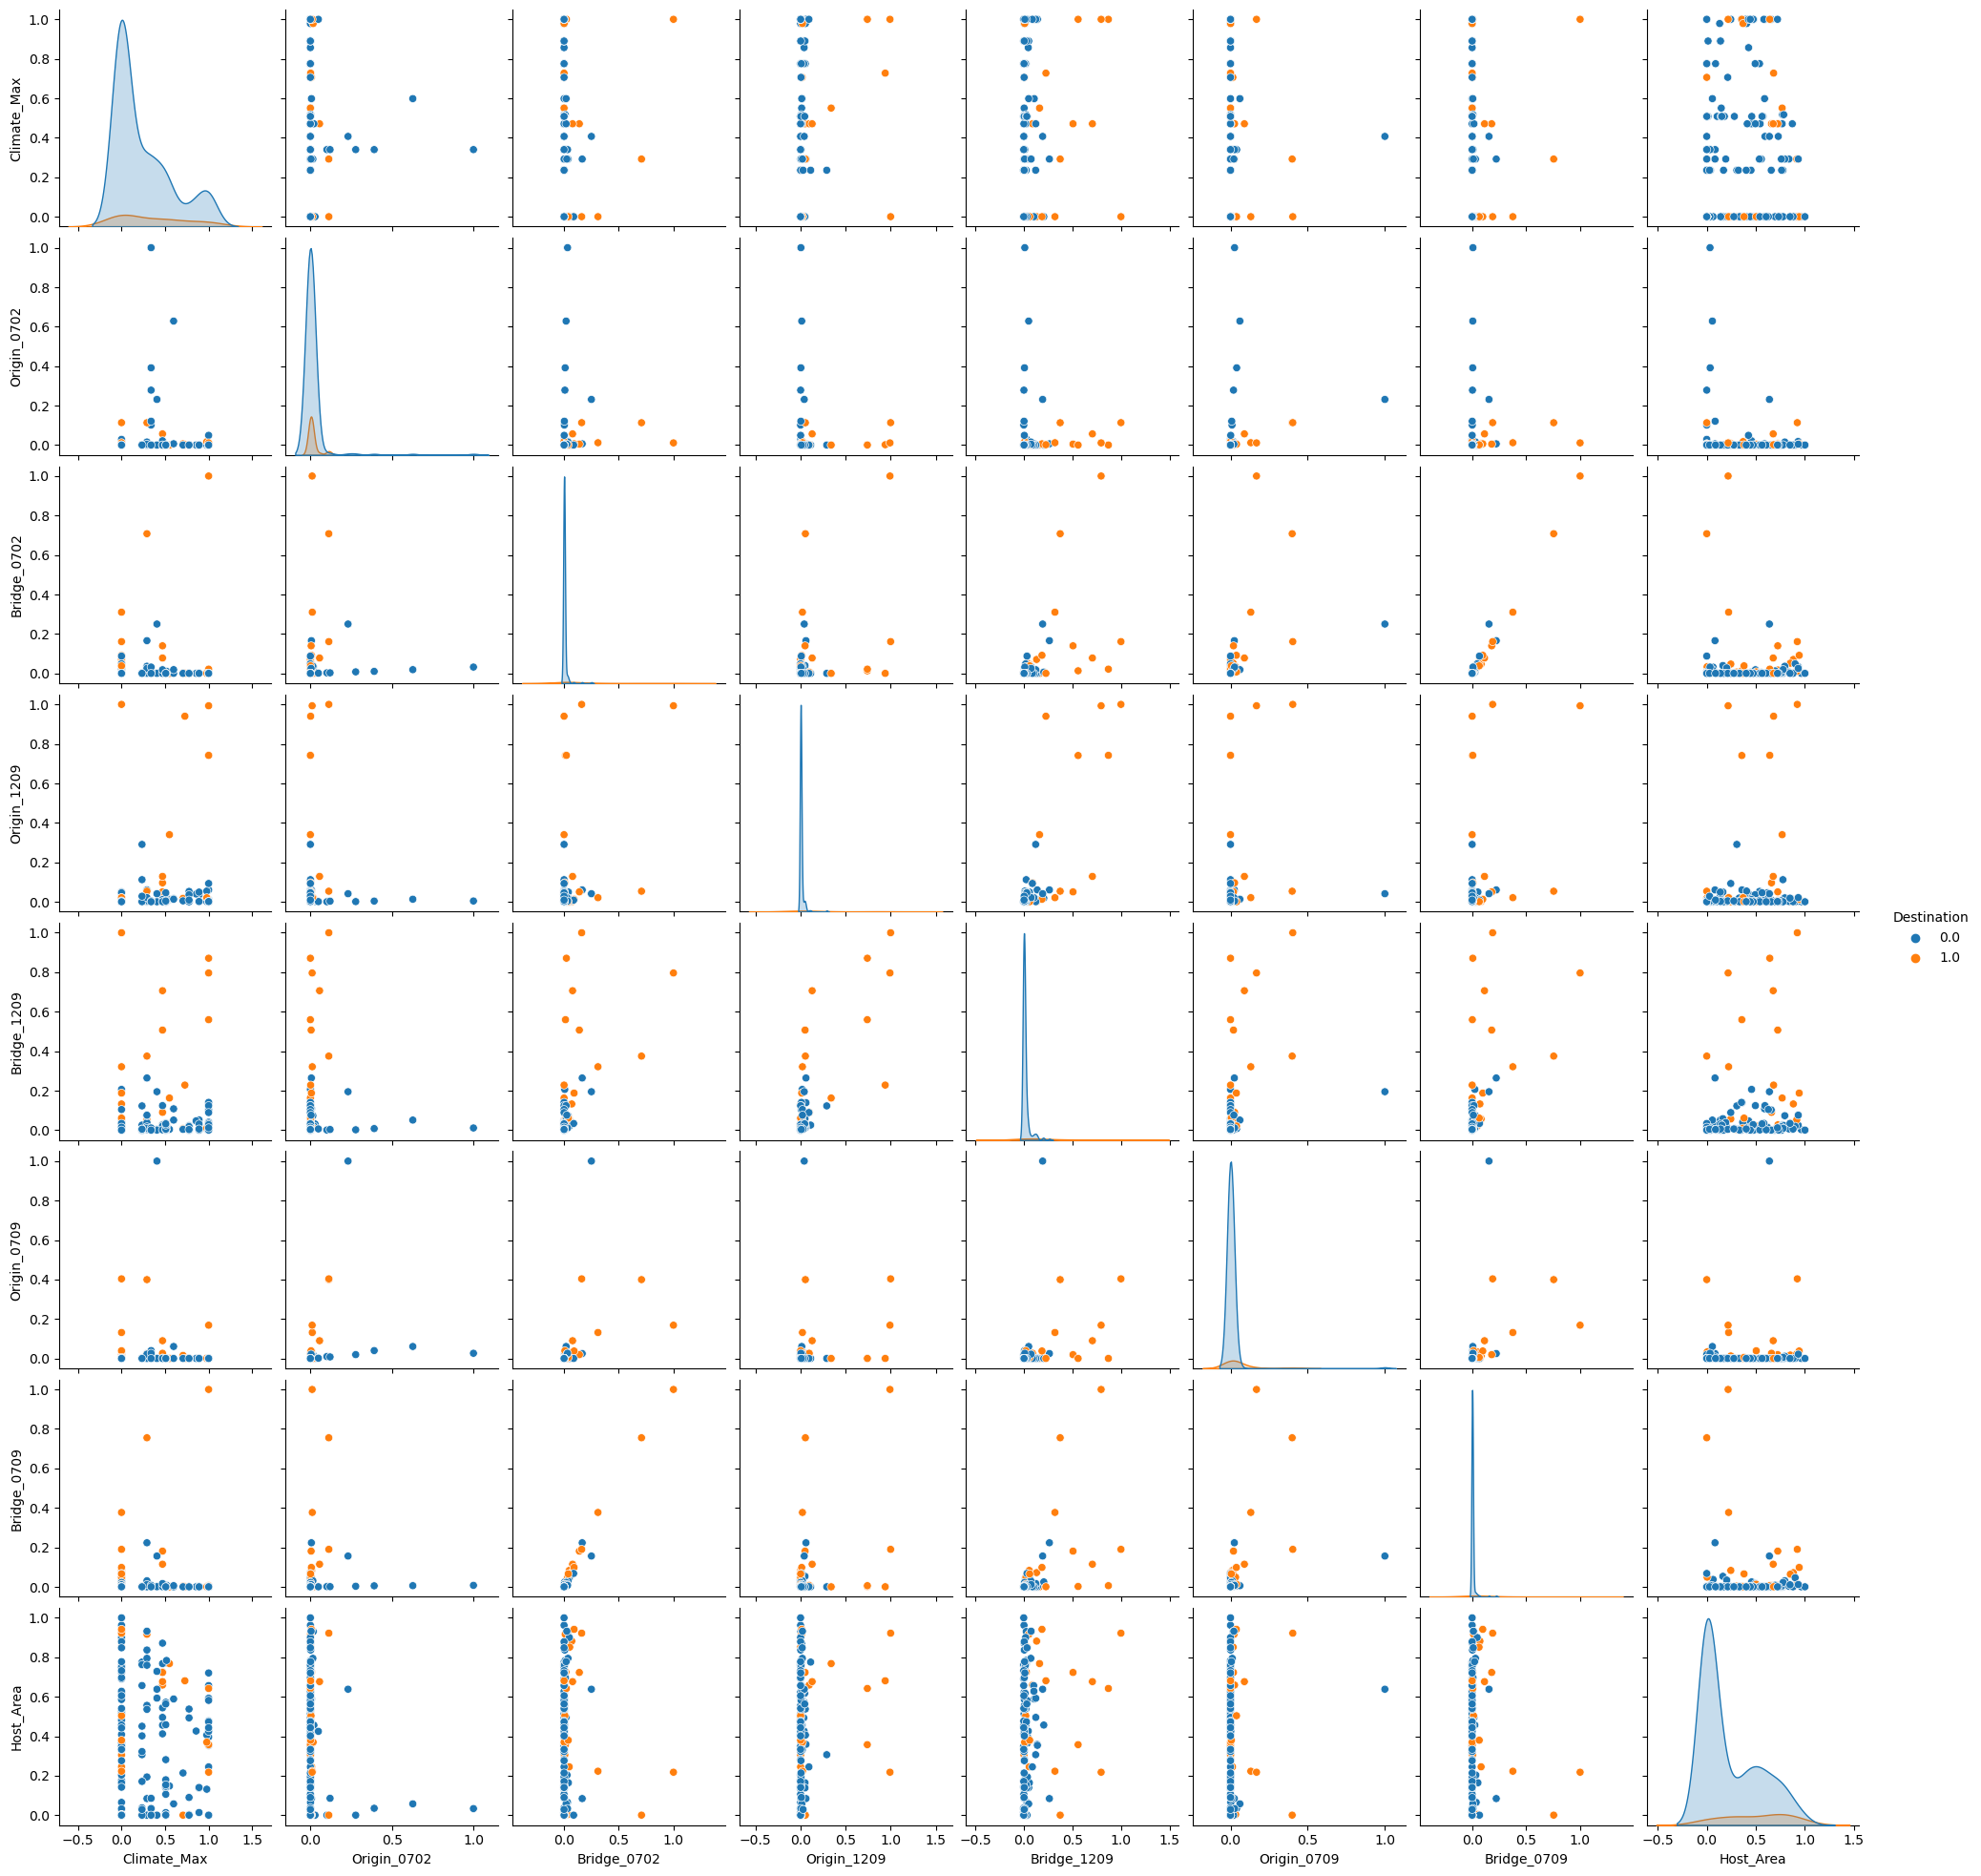

In [14]:
sns.pairplot(regression_data, hue = "Destination")
plt.show()

In [15]:
# Create the regression formula

predictors = regression_data.loc[:,'Climate_Max':'Host_Area'].columns
predictor_string = ' + '.join(predictors)

regression_formula = f'Destination ~ {predictor_string}'

print(f'Regression formula: {regression_formula}')

Regression formula: Destination ~ Climate_Max + Origin_0702 + Bridge_0702 + Origin_1209 + Bridge_1209 + Origin_0709 + Bridge_0709 + Host_Area


In [18]:
y, X = dmatrices(f'Destination ~ {predictor_string}', data=regression_data, return_type='dataframe')

In [19]:
binomial_model = sm.GLM(y, X, family=sm.families.Binomial())
binomial_results = binomial_model.fit()
print(binomial_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Destination   No. Observations:                  231
Model:                            GLM   Df Residuals:                      222
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -42.754
Date:                Wed, 10 Nov 2021   Deviance:                       85.508
Time:                        14:32:32   Pearson chi2:                     236.
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.9991      0.641     -6.241      

## Up next! 

- Random Forest of the same
- Moving to a temporally explicit state-space model (probably in R)